# IBM 推荐系统

在此 notebook 中，你将运用所学的推荐技能处理 IBM Watson Studio 平台的真实数据。 


你可以通过此 workspace 提交 notebook，或者在本地机器上操作并在下个页面提交 notebook。无论是哪种方式，都请确保代码符合项目[审阅标准](https://review.udacity.com/#!/rubrics/2632/view)。**请定期保存代码。**

跟着目录操作，你将能够创建多个不同的推荐方法，这些方法可以用于不同的情形。 


## 目录

I. [探索性数据分析](#Exploratory-Data-Analysis)<br>
II.[基于排名的推荐方法](#Rank)<br>
III.[基于用户-用户的协同过滤](#User-User)<br>
IV.[基于内容的推荐方法（选修内容）](#Content-Recs)<br>
V. [矩阵分解](#Matrix-Fact)<br>
VI.[其他内容和总结](#conclusions)

你可以在 notebook 的结尾处找到提交 notebook 的指南。首先导入必要的库并读取数据。

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

pd.set_option('max_colwidth',200)

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df_content.head(1)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VIDEO IS UNAVAILABLE.\r\nWATCH QUEUE\r\nQUEUE\r\nWatch Queue Queue * Remove all\r\n * Disconnect\r\n\r\nThe next ...",Detect bad readings in real time using Python and Streaming Analytics.,Detect Malfunctioning IoT Sensors with Streaming Analytics,Live,0


In [3]:
df.info(),df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 718.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 24.8+ KB


(None, None)

In [4]:
df.isna().sum(),df_content.isna().sum()

(article_id     0
 title          0
 email         17
 dtype: int64, doc_body           14
 doc_description     3
 doc_full_name       0
 doc_status          0
 article_id          0
 dtype: int64)

In [5]:
# Find and explore duplicate articles
df_content.article_id.duplicated().sum()

5

In [6]:
df_content[df_content.article_id.duplicated(keep=False)].sort_values('article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,"Follow Sign in / Sign up Home About Insight Data Science Data Engineering Health Data AI Never miss a story from Insight Data , when you sign up for Medium. Learn more Never miss a story from Insi...",Community Detection at Scale,Graph-based machine learning,Live,50
365,"Follow Sign in / Sign up Home About Insight Data Science Data Engineering Health Data AI 5 * Share\r\n * 5\r\n * \r\n * \r\n\r\nNever miss a story from Insight Data , when you sign up for Medium. ...",During the seven-week Insight Data Engineering Fellows Program recent grads and experienced software engineers learn the latest open source technologies by building a data platform to handle large…,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\nSearch within Bluemix Blog Bluemix Blog * About Bluemix * What is Bluemix\r\n * Getting Started\r\n * Case Studies\r\n * Hybrid Architecture\...,"When used to make sense of huge amounts of constantly changing data, smart catalog capabilities can make all the difference.",How smart catalogs can turn the big data flood into an ocean of opportunity,Live,221
692,Homepage Follow Sign in / Sign up Homepage * Home\r\n * Data Science Experience\r\n * Data Catalog\r\n * \r\n * Watson Data Platform\r\n * \r\n\r\nSusanna Tai Blocked Unblock Follow Following Offe...,"One of the earliest documented catalogs was compiled at the great library of Alexandria in the third century BC, to help scholars manage, understand and access its vast collection of literature…",How smart catalogs can turn the big data flood into an ocean of opportunity,Live,221
232,Homepage Follow Sign in Get started Homepage * Home\r\n * Data Science Experience\r\n * Data Catalog\r\n * IBM Data Refinery\r\n * \r\n * Watson Data Platform\r\n * \r\n\r\nCarmen Ruppach Blocked ...,"If you are like most data scientists, you are probably spending a lot of time to cleanse, shape and prepare your data before you can actually start with the more enjoyable part of building and…",Self-service data preparation with IBM Data Refinery,Live,232
971,Homepage Follow Sign in Get started * Home\r\n * Data Science Experience\r\n * Data Catalog\r\n * IBM Data Refinery\r\n * \r\n * Watson Data Platform\r\n * \r\n\r\nCarmen Ruppach Blocked Unblock F...,"If you are like most data scientists, you are probably spending a lot of time to cleanse, shape and prepare your data before you can actually start with the more enjoyable part of building and…",Self-service data preparation with IBM Data Refinery,Live,232
399,Homepage Follow Sign in Get started * Home\r\n * Data Science Experience\r\n * Data Catalog\r\n * IBM Data Refinery\r\n * \r\n * Watson Data Platform\r\n * \r\n\r\nSourav Mazumder Blocked Unblock ...,"Today’s world of data science leverages data from various sources. Commonly, these sources are Hadoop File System, Enterprise Data Warehouse, Relational Database systems, Enterprise file systems, ...",Using Apache Spark as a parallel processing framework for accessing REST based data services,Live,398
761,Homepage Follow Sign in Get started Homepage * Home\r\n * Data Science Experience\r\n * Data Catalog\r\n * IBM Data Refinery\r\n * \r\n * Watson Data Platform\r\n * \r\n\r\nSourav Mazumder Blocked...,"Today’s world of data science leverages data from various sources. Commonly, these sources are Hadoop File System, Enterprise Data Warehouse, Relational Database systems, Enterprise file systems, ...",Using Apache Spark as a parallel processing framework for accessing REST based data services,Live,398
578,This video shows you how to construct queries to access the primary index through the API.Visit http://www.cloudant.com/sign-up to sign up for a free Cloudant account. Find more videos and tutoria...,This video shows you how to construct queries to access the primary index through Cloudant's API.,Use the Primary Index,Live,577
970,This video shows you how to construct queries to access 

以上article_id重复的文章均为同一篇文章，只是文章的描述有些出入，可以删除

In [7]:
df.duplicated().sum()

12311

***df***
- email：代表了用户，可以自定义id代替
- article_id：改成str
- email：存在17个缺失值，即为无法辨认身份的user
- ~存在12311个重复值，但是该数据集为用户与文章存在互动的数据，所以可能同一个用户对于同一篇可能存在多次互动，所以无须删除重复值~

***df_content***
- article_id：改成str
- `doc_body`和`doc_description`存在缺失值
- 存在重复值，需要删除

### <a class="anchor" id="Exploratory-Data-Analysis">第一部分：探索性数据分析</a>

通过以下字典和单元格了解数据的描述性统计信息。

`1.` 用户与数据集中的多少篇文章互动了？分布如何？以图表的形式描述每个用户与某篇文章互动的次数。

In [8]:
# 修改article_id
df_content.article_id = df_content.article_id.astype('str')
df.article_id = df.article_id.astype('str')

In [9]:
df.info(),df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null object
title         45993 non-null object
email         45976 non-null object
dtypes: object(3)
memory usage: 539.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null object
dtypes: object(5)
memory usage: 20.7+ KB


(None, None)

In [10]:
# 计算user-article interactions by user
use_ints_nums = df.groupby('email').size()
use_ints_nums.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
dtype: float64

In [11]:
# Fill in the median and maximum number of user_article interactios below
median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

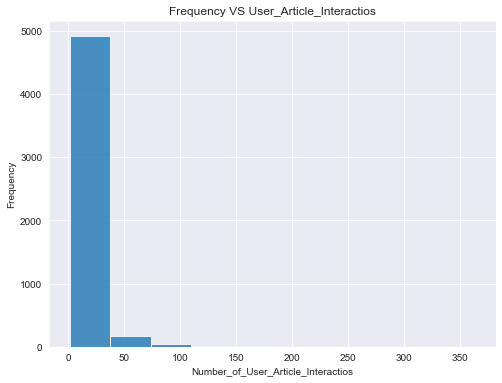

In [12]:
# 可视化user_article interactios的数据分布
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
plt.hist(use_ints_nums,alpha=0.8);
plt.xlabel('Number_of_User_Article_Interactios')
plt.ylabel('Frequency')
plt.title('Frequency VS User_Article_Interactios');

该数据集存在极大值，为了更清楚地分析整个数据集的分布，将极大值去除，将X轴数据范围缩小至50

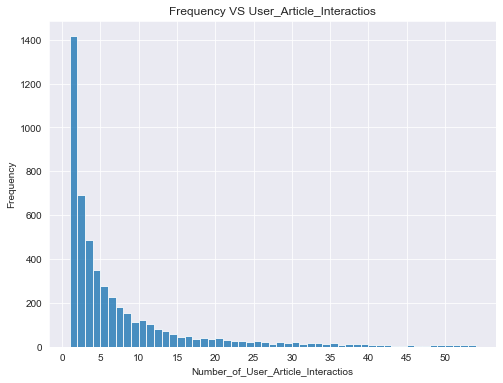

In [13]:
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
bin_edges = np.arange(1, 50+5, 1)
plt.hist(use_ints_nums,bins=bin_edges, alpha=0.8)
plt.xticks(np.arange(0,50+5,5),np.arange(0,50+5,5))
plt.xlabel('Number_of_User_Article_Interactios')
plt.ylabel('Frequency')
plt.title('Frequency VS User_Article_Interactios');

50%的用户与平台中的文章互动次数在1-3次，75%的用户与平台的互动次数在10次以下，其中仅与平台其中1篇文章有所互动的用户约占25%，由于该数据集存在极大值，所以拉高了整个数据集的平均互动次数

`2.` 发现并移除 **df_content** dataframe 中的重复文章。

In [14]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id',inplace=True)

In [15]:
df_content.article_id.duplicated().sum()

0

`3.` 在以下单元格中查找：

**a.**用户与之互动的唯一文章数量。  
**b.**数据集中的唯一文章数量（无论用户是否与之互动了）。<br>
**c.**数据集中的唯一用户数量。（不包括空值）<br>
**d.**数据集中的用户-文章互动次数。

In [16]:
unique_articles = df.article_id.nunique()# The number of unique articles that have at least one interaction
total_articles = df_content.shape[0] # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` 在以下单元格中查找查看次数最多的文章的 **article_id**，以及被查看频率。在与公司领导讨论后，`email_mapper` 函数被视为将用户映射到 ID 的合理方式。有少数几个空值，并且所有这些空值都可能属于一个用户（我们以这种方式使用以下函数存储了这些值）。

In [17]:
# 探索最多被查看和互动的文章及其被查看的频率
df.groupby('article_id').size()[df.groupby('article_id').size() == df.groupby('article_id').size().max()]

article_id
1429.0    937
dtype: int64

In [18]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [19]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [20]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">第二部分：基于排名的推荐方法</a>

与之前的课程不同，我们没有关于用户是否喜欢某篇文章的评分。我们只知道用户与文章互动了。在这些情形下，文章的热门程度只能通过用户与文章的互动频率来判断。

`1.` 填写以下函数，使其返回前 **n** 篇文章，按照互动次数从高到低排序。使用以下测试测试你的函数。

In [21]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    ints_by_user = df.groupby('article_id').size()
    sort_by_views = ints_by_user.sort_values(ascending=False)
    
    top_articles = list(df[df['article_id'].isin(sort_by_views.iloc[:n].index)]['title'].unique())
    
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles_ids - (list) A list of the top 'n' article titles ids
    
    '''
    ints_by_user = df.groupby('article_id').size()
    sort_by_views = ints_by_user.sort_values(ascending=False)
    total_article_ids = list(sort_by_views.iloc[:n].index)
 
    return total_article_ids # Return the top article ids

In [22]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [23]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">第三部分：基于用户-用户的协同过滤</a>


`1.` 使用以下函数调整 **df** dataframe 的形状，使行表示用户，并使列表示文章。  

* 每个**用户**只能在每**行**中出现一次。


* 每篇**文章**只能在每**列**中出现一次。  


* **如果用户与某篇文章互动了，则在该文章所在的列与用户行形成的单元格中填充 1**。无论用户与文章互动了多少次，都填充 1。  


* **如果用户与文章没有互动，则在该文章所在的列与用户行形成的单元格中填充 0**。 

使用以下测试检验矩阵的基本结构是否与解答中的结构一致。

In [24]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df_matrix = df.groupby(['user_id','article_id']).size().unstack()
    
    df_matrix_np = np.where(df_matrix>=1, 1, 0)
    
    user_item = pd.DataFrame(data=df_matrix_np, index=df_matrix.index, columns=df_matrix.columns)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [25]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` 完成以下函数，该函数应该接受 user_id，并提供与该用户最相似的有序用户列表（从最相似到最不相似）。返回的列表不应包含提供的 user_id，因为我们知道每个用户都与其本身相似。因为每个用户的结果是二元的，所以建议用两个用户的点积表示相似性。 

使用测试测试你的函数。

In [26]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_item_values = np.array(user_item)
    
    user_similarity = np.dot(user_item.loc[user_id].values, user_item_values.transpose())

    # sort by similarity and create list of just the ids
    sort_similar_user_ids = np.array(user_item.iloc[np.argsort(user_similarity)[::-1]].index)
   
    # remove the own user's id
    most_similar_users = list(sort_similar_user_ids[sort_similar_user_ids != user_id])
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [27]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` 创建了为每个用户提供最相似用户的函数后，你需要使用这些用户查找可以推荐的文章。完成以下函数，以返回向每个用户推荐的文章。

In [28]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = [df[df['article_id'] == article_id]['title'].unique()[0] for article_id in article_ids]
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    
    article_ids = np.array(user_item.loc[user_id][user_item.loc[user_id] == 1].index)
    
    article_names = get_article_names(article_ids)
    
    
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    seen_article_ids = get_user_articles(user_id)[0]
    most_similar_users = find_similar_users(user_id)
    
    recs = np.array([])
    
    for _id in most_similar_users:
        
        if len(recs) < m:
            not_seen_articles = np.setdiff1d(get_user_articles(_id)[0], seen_article_ids)
            recs = np.concatenate((recs, not_seen_articles))
        
        else:
            break
    
    return list(recs) # return your recommendations for this user_id    

In [29]:
# test user_user_recs results
len(user_user_recs(1, 10))

118

In [30]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` 现在我们将提高上述 **user_user_recs** 函数的一致性。  

* 当所有用户与给定用户的邻近程度都一样时，我们并非随意选择用户，而是先选择总互动次数最多的用户，然后选择互动次数第二多的用户。


* 当推荐的文章数量以低于 m 的数字开始并以高于 m的数字结束时，我们并非随意选择文章，而是先选择总互动次数最多的文章，然后选择总互动次数第二多的文章。你可以利用之前编写的 **top_articles** 函数获得这种排名。

In [31]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # same as find_similar_users function
    
    similarity = np.dot(user_item.loc[user_id].values, np.array(user_item).transpose())
    similarity_series = pd.Series(data=similarity, index=user_item.index, name='similarity')
    num_interactions = pd.Series(df.groupby('user_id').size(), name='num_interactions')
    demo_df = pd.concat([similarity_series, num_interactions], axis=1).reset_index()
        
        
   
   
    # remove the own user's id

    neighbors_df = demo_df[demo_df['user_id'] != user_id].rename(columns={'user_id':'neighbor_id'}).set_index('neighbor_id')
    
    # sort the neighbors_df by the similarity and then by number of interactions
    
    neighbors_df = neighbors_df.sort_values(['similarity','num_interactions'],ascending=False)
    
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    try: 
        seen_article_ids = get_user_articles(user_id)[0] # get the article ids that the user has viewed
        neighbor_ids = get_top_sorted_users(user_id).index # get the neighbors for the user 
        aritcle_views_rank = np.array(get_top_article_ids(unique_articles)) # from get_top_article_ids() to get article views rank

        recs = np.array([])

        for i, _id in enumerate(neighbor_ids):

            not_seen_articles = np.setdiff1d(get_user_articles(_id)[0], seen_article_ids)

            recs = np.concatenate((recs, not_seen_articles))

            if (i == 0) and (len(recs) >= m): # start with number of recs more than m, return the recs directly

                break

            elif (len(recs) >= m): # start with number of recs less than m and end with number of recs more than m, return the ariticle list sorted by views

                recs = aritcle_views_rank[np.isin(aritcle_views_rank, recs)] # according aritcle_views_rank's order to sort recs article
                break

            else:
                continue
    
    except:
        print('this user {} not in the data, like to make recommendation based on article views rank :\n'.format(user_id))
        
        recs = get_top_article_ids(m)
        
        
    if len(recs) > m:
        recs = list(recs)[:m]
    else:
        recs = list(recs)
            
        
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [32]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: chicago listings', 'tensorflow quick tips', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark']


`5.` 请利用上述函数正确填写以下字典。然后对照解答检验该字典。按照以下注释提供必要的代码。

In [33]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).index[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).index[9]# Find the 10th most similar user to user 131

In [34]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` 如果是新用户，你可以使用上述哪个函数做出推荐？请解释。你能想到更好的推荐方法吗？在以下单元格中解释向新用户做出推荐的更好方法。

**如果是新用户，即user_id不存在user_item里，无法获取该用户与其他用户的相似性，所以无法通过user_user_part2的方法做出推荐，但是可以使用基于排名的方法:get_top_articles向其推荐互动量较大的文章。更好的推荐方法是：新用户采用基于排名get_top_articles方法对其作出推荐，并将其融合至user_user_recs_part2**

`7.` 利用现有函数向以下新用户提供前 10 篇推荐文章。你可以对照我们的解答测试你的函数，确保在如何做出推荐方面与我们的想法一致。

In [35]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = user_user_recs_part2(new_user,m=10)[0]# Your recommendations here
new_user_recs

this user 0.0 not in the data, like to make recommendation based on article views rank :



['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [36]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">第四部分：基于内容的推荐方法（选修内容）</a>

另一种推荐方法是对与某个术语相关的文章进行从高到低排名。内容可以是 **doc_body**、**doc_description** 或**doc_full_name**。创建基于内容的推荐系统并非只有一种方式，尤其是考虑到每列都包含与内容相关的信息。  

`1.` 使用以下函数主体创建一个基于内容的推荐系统。由于这个推荐系统的正确答案不止一个，所以没有提供测试函数。如果你想尝试一种需要更多输入值的方法，可以更改函数输入。当前的输入值考虑到了你可能会使用基于内容的推荐方法。此外，你可能会使用满足“内容标准”的最热门推荐方法，总之，你在做出这些推荐时可以灵活选择方法。

### 这部分并非通过项目必须完成的任务。但是，你可以借机展示你的技能。

In [223]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VIDEO IS UNAVAILABLE.\r\nWATCH QUEUE\r\nQUEUE\r\nWatch Queue Queue * Remove all\r\n * Disconnect\r\n\r\nThe next ...",Detect bad readings in real time using Python and Streaming Analytics.,Detect Malfunctioning IoT Sensors with Streaming Analytics,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data science: A guide to presenting your work 4COMMUNICATING DATA SCIENCE: A GUIDE TO PRESENTING YOUR WORK\r\nMegan ...,"See the forest, see the trees. Here lies the challenge in both performing and presenting an analysis. As data scientists, analysts, and machine learning engineers faced with fulfilling business obj…",Communicating data science: A guide to presenting your work,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Paths\r\n * Courses * Our Courses\r\n * Partner Courses\r\n \r\n \r\n * Badges * Our Badges\r\n * BDU Badge Program\r\n \r\n \r\n * Watson ...,Here’s this week’s news in Data Science and Big Data.,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCALE - BOOST THE PERFORMANCE OF YOUR\r\nDISTRIBUTED DATABASE\r\nShare on Twitter Share on Facebook Share on Google+ Vote on Hacker News Published Dec 29...","Learn how distributed DBs solve the problem of scaling persistent storage, but introduce latency as data size increases and become I/O bound.",DataLayer Conference: Boost the performance of your distributed database,Live,3
4,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VIDEO IS UNAVAILABLE.\r\nWATCH QUEUE\r\nQUEUE\r\nWatch Queue Queue * Remove all\r\n * Disconnect\r\n\r\nThe next ...",This video demonstrates the power of IBM DataScience Experience using a simple New York State Restaurant Inspections data scenario.,Analyze NY Restaurant data using Spark in DSX,Live,4


In [228]:
# 清理df_content
df_content.doc_full_name = df_content.doc_full_name.str.lower()
df_content.article_id = df_content.article_id.astype('float').astype('str')


In [229]:
df_content.doc_description = df_content.doc_description.fillna(df_content.doc_full_name)

In [184]:
# based on content means analyse the key words in article, spliting doc_description or doc full name will be suitable for the project
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [185]:
Stopwords = set(stopwords.words('english'))

# tokenize and normalize the text
def tokenize(text):
    text= re.sub(r'[\W+]|[\d+]', ' ', text)
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = []
    for tok in tokens:    
        clean_tok = lemmatizer.lemmatize(tok, pos='v').lower().strip()
        if clean_tok not in Stopwords:
            clean_tokens.append(clean_tok)
    
    return clean_tokens

In [232]:
# create the content tfidf matrix
from sklearn.pipeline import Pipeline

doc_descrips = df_content.doc_description.values
pipe = Pipeline([('vect', CountVectorizer(tokenizer=tokenize)),
         ('tfidf', TfidfTransformer())])
pipe.fit(doc_descrips)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x359012B8>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True))],
         verbose=False)

In [233]:
content_mat = pipe.transform(doc_descrips).toarray()

In [236]:
# 使用点积法计算文章之间的相似性
def find_articles_similarity(article_id, df=df_content):
    dot_prod_article = np.dot(content_mat, content_mat.transpose())
    
    idx = np.where(df_content['article_id'] == article_id)[0][0]
    sort_by_similar_idx = np.argsort(dot_prod_article[idx])[::-1]
    
    similar_article_ids = np.array(df_content.iloc[sort_by_similar_idx]['article_id'])
    similar_article_names = np.array(df_content.iloc[sort_by_similar_idx]['doc_full_name'])
    return similar_article_ids, similar_article_names

In [237]:
find_articles_similarity('0.0')[0][:10]

array(['0.0', '730.0', '470.0', '194.0', '53.0', '1005.0', '266.0',
       '980.0', '423.0', '681.0'], dtype=object)

In [38]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    
    
    
    
    
    
    
    
    
    
    '''

`2.` 你已经创建了基于内容的推荐系统，接着在以下单元格中简要说明下这一基于内容的推荐系统是如何运行的。你觉得你的函数有哪些值得改进的地方吗？这一基于内容的推荐系统有什么新奇的地方吗？

### 这部分并非通过项目必须完成的任务。但是，你可以借机展示你的技能。

**在此处解释下这一基于内容的推荐系统。**

`3.` 根据注释使用这一基于内容的推荐系统对以下情形做出推荐。我们没有提供测试，因为在创建此基于内容的推荐系统时，可以有多个正确答案。

### 这部分并非通过项目必须完成的任务。但是，你可以借机展示你的技能。

In [39]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">第五部分：矩阵分解</a>

在此部分，你将利用矩阵分解向 IBM Watson Studio 平台上的用户推荐文章。

`1.` 你在上述**第三部分**的**第一个问题**中已经创建了 **user_item** 矩阵。接下来的第一个问题需要你运行单元格，为**第五部分**的其他步骤做好准备。

In [37]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [38]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` 在此部分，你可以对用户-项目矩阵运用[numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) 的奇异值分解方法。在单元格中执行 SVD，并解释为何与课程中的步骤不一样。

In [39]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In [40]:
np.diag(s).shape, vt.shape, u.shape

((714, 714), (714, 714), (5149, 5149))

In [41]:
# test the correctly of svd
np.allclose(np.array(user_item_matrix), np.dot(u[:,:714], np.dot(np.diag(s),vt)))

True

**课程中涉及到的项目数量较少，相应的潜在因子的数量也较少，所以对于保留多少个潜在因子的问题可以通过测算各个潜在因子对于解释原始矩阵的变化量的大小，即s矩阵对角线上的值占对角线元素的平方和的百分比。但是本项目所涉及的项目数量共有714个，不能通过手动测算各个分量的占比而得出其重要性，需要通过for循环可视化的方法，得出潜在因子数量对于解释原始矩阵的变化量**

`3.` 如何确定潜在特征的数量？这个问题比较难。运行以下单元格后你会发现，随着潜在特征数量的增加，用户-项目矩阵中 1 和 0 值的预测错误率会降低。运行以下单元格，了解当潜在特征的数量增加时，准确率会如何提高。

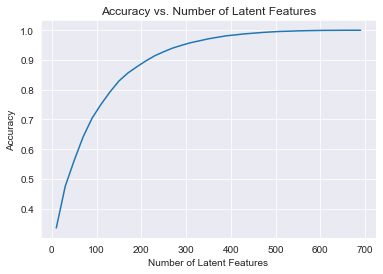

In [42]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [95]:
s_new, u_new, vt_new = np.diag(s[:500]), u[:, :500], vt[:500, :]

# take dot product
user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

In [96]:
np.unique(user_item_est)

array([0., 1.])

In [88]:
user_item_est[0,3]

-0.0

`4.` 通过上述单元格，我们无法判断要使用多少个潜在特征，因为能够更好地预测矩阵的 1 和 0 值，并不表明我们就能做出很好的推荐。我们可以将数据集划分为训练集和测试集，如以下单元格所示。  

根据第三个问题的代码判断，不同的潜在特征数量对训练集和测试集的准确率有何影响。使用以下划分方法： 

* 我们可以对测试集中的多少个用户做出预测？  
* 由于冷启动问题，我们无法对多少个用户做出预测？
* 我们可以对测试集中的多少篇文章做出预测？  
* 由于冷启动问题，我们无法对多少篇文章做出预测？

In [43]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = np.array(user_item_test.index)
    test_arts = np.array(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [44]:
# How many users can we make predictions for in the test set
np.intersect1d(test_idx, user_item_train.index).shape

(20,)

In [45]:
# How many users in the test set are we not able to make predictions
np.setdiff1d(test_idx, user_item_train.index).shape

(662,)

In [46]:
# How many articles can we make predictions for in the test set
np.intersect1d(test_arts, user_item_train.columns).shape

(574,)

In [47]:
# How many articles are we not able to make predictions for in the test set
np.setdiff1d(test_arts, user_item_train.columns).shape

(0,)

In [48]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` 现在对上述 **user_item_train** 数据集进行奇异值分解，并得出 U、S 和 V 转置矩阵。然后判断在使用不同的潜在特征数量时，可以使用此矩阵分解方法对 **user_item_test** 数据集中的多少行做出预测，并根据测试数据的准确率确定应该保留多少个潜在特征。这个问题需要运用在第 `2` - `4`.个问题中完成的步骤。

通过以下单元格了解 SVD 在测试数据上做出推荐预测的效果如何。

In [49]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

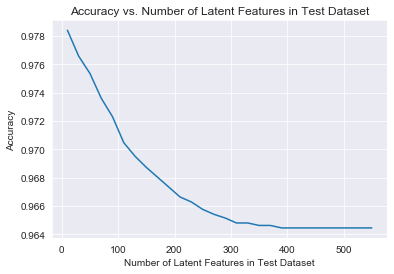

In [55]:
# explore how many latent factors will be remained that can improve the accuracy of prediciton

n_test_latent_feats = np.arange(10, 560+10, 20)

test_user_ids = np.intersect1d(test_idx, user_item_train.index)
test_article_ids = np.intersect1d(test_arts, user_item_train.columns)
user_idxs = [np.where(user_item_train.index == _id)[0][0] for _id in test_user_ids]
article_idxs = [np.where(user_item_train.columns == aritcle_id)[0][0] for aritcle_id in test_article_ids]

test_sum_errs = []
for k in n_test_latent_feats:

    u_train_new, s_train_new, vt_train_new = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    test_preds = user_item_train_est[user_idxs, :][:, article_idxs]
    test_diffs = np.subtract(user_item_test.loc[test_user_ids, test_article_ids], test_preds)
    test_err = np.sum(np.sum(np.abs(test_diffs)))
    test_sum_errs.append(test_err)

plt.plot(n_test_latent_feats, 1 - np.array(test_sum_errs)/df_test.loc[])
plt.xlabel('Number of Latent Features in Test Dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features in Test Dataset');

- 该矩阵分解方法仅能够对 user_item_test 数据集中的20行即20个用户做出预测；
- 对于这20个用户而言，潜在因子数量越少，预测效果越好，从上图可以看到当潜在因子数量为10个时，拟合效果达到最佳；
- 该现象表明，从训练数据拟合出的潜在因子，对于测试数据集可预测的用户，第一个的潜在因子的起到了关键性作用

In [98]:
u_train_new, s_train_new, vt_train_new = u_train[:, :10], np.diag(s_train[:10]), vt_train[:10, :]
user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))

In [99]:
np.unique(user_item_train_est)

array([-1., -0.,  1.,  2.])

In [73]:
# 使用funksvd
n_user = user_item_train.shape[0]
n_item = user_item_train.shape[1]
n_train_latent_feats = np.arange(10, 700+10, 20)

In [82]:
def Funksvd(user_item_mat, latent_features, lr= 0.001, iters=10):
        
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization

    Input:
    user_item_mat - the user_item_matrix
    latent_features - (int) the number of latent features used
    lr - (float) the learning rate, default value is 0.001
    iters - (int) the number of iteration, defalut value is 100
    '''
    view_mat = np.matrix(user_item_mat)
    user_ids_series = user_item_mat.index
    aritcle_ids_series = user_item_mat.columns

    # complete FunkSVD
    n_users = view_mat.shape[0]
    n_articles = view_mat.shape[1]
    
    # initialize user_mat and movie_mat
    user_mat = np.random.rand(n_users, latent_features)
    article_mat = np.random.rand(latent_features, n_articles)
    # initialize num_rarting and accum_sse
    num_ratings = 0
    accum_sse = 0

    # keep track of iteration and MSE
#     print("Optimizaiton Statistics")
#     print("Iterations | Mean Squared Error ")
    # For each iteration
    for iteration in range(iters):
        accum_sse = 0

        # For each user_movie pair
        for i in range(n_users):
            for j in range(n_articles):
                if (view_mat[i, j] == 1):
                    pred = np.dot(user_mat[i,:], article_mat[:,j])
                    accum_sse += (view_mat[i,j] - pred) ** 2
                    num_ratings += 1

                    # update user_mat and movie_mat
                    for k in range(latent_features):
                        user_mat[i, k] += lr * 2 * (view_mat[i,j] - pred) * article_mat[k, j]
                        article_mat[k, j] += lr * 2 * (view_mat[i,j] - pred) * user_mat[i, k]
        # print each iteration result
#         print('%d \t\t %f' % (iteration+1, accum_sse / num_ratings))

    # FunkSVD based fit
    # keep user_mat and movie_mat for self keeping
    user_mat = user_mat
    article_mat = article_mat
    
    return (accum_sse / num_ratings), user_mat, article_mat

In [83]:
mse_list = []
for n_feats in n_train_latent_feats:
    mse = Funksvd(user_item_train, n_feats)[0]
    mse_list.append(mse)

plt.plot(n_train_latent_feats, np.array(mse_list))
plt.xlabel('Number of Latent Features in Test Dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features in Test Dataset');

KeyboardInterrupt: 

`6.` 在以下单元格中解释上个问题的结果。根据你得出的结果，讨论下你会如何判断上述推荐系统是否比用户目前查找文章的方式更好。 

**通过奇异分解法对潜在因子进行推断，相比较以上根据user之间的相似性做出推荐，奇异分解法的准确性更高。**

<a id='conclusions'></a>
### 其他内容
你现在可以保存为每个用户推荐的文章，开发一个类来作出新的预测并更新结果，以及创建一个部署结果的应用。这些任务并不是此项目必须完成的任务。但是，在学完课程知识后，你肯定能够继续完成这些任务并改进你的项目。


## 总结

> 恭喜！你已经完成 IBM 推荐系统项目。 

> **小贴士**：当你对项目满意后，请检查报告并看看是否满足所有[审阅标准](https://review.udacity.com/#!/rubrics/2632/view)。请删除所有的**小贴士**（例如上方小贴士），使演示尽可能流畅。


## 提交指南

> 在提交项目之前，你需要在 workspace 的此部分创建 notebook 的 .html 或 .pdf 版本。运行以下单元格即可创建这两种版本。如果操作正确，系统会返回代码 0，并且你可以在 workspace 目录（点击左上角的橙色 Jupyter 图标）中看到生成的 .html 文件。

> 或者，你可以通过**文件** > **下载为**子菜单将此报告下载为 .html 文件，然后手动将报告上传到 workspace 目录中：点击左上角的橙色 Jupyter 图标，然后点击“上传”按钮。

> 完成这些步骤后，你可以点击右下角的“提交项目”按钮，提交项目。这样便会创建和提交一个 zip 文件，其中包含此 .ipynb 文件和你创建的 .html 或 .pdf 文件。恭喜！ 


```python
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])
```